# Tatoeba: N-Gram Hashing

Author: Pierre Nugues

In this notbook, we will reduce the size of the n-gram vectors using hashing techniques

This is a preliminary step to understand language detection and CLD3, https://github.com/google/cld3

In [1]:
import random
from collections import Counter
import torch
import matplotlib.pyplot as plt

In [2]:
random.seed(4321)
torch.manual_seed(4321)

## Reading the Dataset

In [3]:
FILE = 'sentences.csv'

Adjust your path

In [4]:
SMALL_DATASET_PATH = '.'
LARGE_DATASET_PATH = '.'

In [5]:
SMALL = False

In [6]:
if SMALL:
    dataset_path = SMALL_DATASET_PATH
else:
    dataset_path = LARGE_DATASET_PATH
    
WORKING_FILE = dataset_path + '/' + FILE

We create a generator

In [7]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [8]:
line_generator = file_reader(WORKING_FILE)

And we count the sentences per language

In [9]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [10]:
lang_freqs.most_common(15)

[('eng', 1919655),
 ('rus', 1083677),
 ('ita', 888171),
 ('epo', 766363),
 ('tur', 734304),
 ('kab', 722477),
 ('deu', 694683),
 ('ber', 676645),
 ('fra', 627564),
 ('por', 433886),
 ('hun', 411068),
 ('spa', 408395),
 ('jpn', 241802),
 ('heb', 201539),
 ('ukr', 186322)]

In [11]:
langs = sorted(list(set(lang_freqs.keys())))
langs[:10]

['\\N', 'abk', 'acm', 'ady', 'afb', 'afh', 'afr', 'aii', 'ain', 'ajp']

## Extracting n-grams

In [12]:
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    if lc:
        sentence = sentence.lower()
    for i in range(len(sentence) - n + 1):
        ngram_l += [sentence[i:i+n]]
    return ngram_l

In [13]:
def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [14]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

## Extracting n-grams from the corpus

In [15]:
def extract_ngrams():
    with open(WORKING_FILE, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            lang = lang_tuple[1]
            if lang in langs:
                yield all_ngrams(lang_tuple[2])       

We assume three, otherwise we have to create a list

In [16]:
charset = set()
bigram_set = set()
trigram_set = set()

In [17]:
for triple in extract_ngrams():
    charset.update(triple[0])
    bigram_set.update(triple[1])
    trigram_set.update(triple[2])


In [18]:
len(charset), len(bigram_set), len(trigram_set)

(10854, 361766, 1536870)

## Hashing the n-grams and limiting their numbers

In [19]:
hash('ads'), hash('ads') % 100

(-5072967176214789791, 9)

In [20]:
if SMALL:
    MAX_CHARS = 521
    MAX_BIGRAMS = 1031
    MAX_TRIGRAMS = 1031  
else:
    MAX_CHARS = 2053
    MAX_BIGRAMS = 4099
    MAX_TRIGRAMS = 4099  #8192

In [21]:
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
NUM_FEATURES

10251

In [22]:
def hash_conflicts(symbol_set, modulo):
    conflict_dict = dict()
    for symb in symbol_set:
        hash_code = hash(symb) % modulo
        if hash_code in conflict_dict:
            conflict_dict[hash_code] += [symb]
        else:
            conflict_dict[hash_code] = [symb]
    return conflict_dict

In [23]:
hash_conflicts_1 = hash_conflicts(charset, MAX_CHARS)
hash_conflicts_2 = hash_conflicts(bigram_set, MAX_BIGRAMS)
hash_conflicts_3 = hash_conflicts(trigram_set, MAX_TRIGRAMS)

In [24]:
hash('a') % 2053

879

In [25]:
hash_conflicts_1[1308]

['ओ', '潮', '駁', '킹']

In [26]:
hash('abc') % 4099

2815

In [27]:
hash_conflicts_3[672]

[' ଦ୍',
 'のは当',
 '友还可',
 'ڭ ق',
 '们是来',
 'തൂ.',
 '고합니',
 'u į',
 'は伝達',
 'ーの父',
 '明显大',
 '켄은 ',
 'yeo',
 'もの結',
 'は宿屋',
 '続人と',
 'הלי',
 'জক ',
 '思考。',
 'rdî',
 'យ \u200b',
 'のらし',
 'た死な',
 '沒有粘',
 '到你自',
 'aei',
 '員均須',
 '歡化美',
 'ة/ا',
 'ain',
 '良いベ',
 'צום',
 'ば、彼',
 'ητέ',
 'ಸಿದ',
 '英語多',
 '了，吾',
 'ास!',
 '水管被',
 ' µε',
 'ौ र',
 '心者勝',
 '日に始',
 '이 듭',
 '്ണാ',
 '저했어',
 'りも筋',
 '我慢出',
 '都會俾',
 '間便通',
 '読むん',
 '活个？',
 'فم.',
 'די.',
 'péy',
 'ይነጥ',
 '勤而行',
 '解決で',
 '\xa0vi',
 '被廢氣',
 'pāg',
 '何年待',
 'かお助',
 'yáa',
 'ɣ ḥ',
 '빠르네',
 '入るん',
 'm在b',
 'വസി',
 'ሒፍዎ',
 '売を譲',
 '去音乐',
 '直视我',
 '沒別的',
 'چەخ',
 '一の手',
 ' "ш',
 '變老了',
 '方侪会',
 ' εu',
 'ोलं',
 '院比较',
 'mḏ-',
 'く滑ら',
 '在省钱',
 '变成老',
 '要打断',
 '是电吉',
 '左转却',
 'トはき',
 'hə.',
 'クとは',
 'いたわ',
 'ibl',
 '負の見',
 '的習慣',
 '幸因素',
 '¿mu',
 '体およ',
 'կ մ',
 '張空床',
 '夫人だ',
 'תדי',
 'ခုတ',
 '待到六',
 '有不懂',
 '０分は',
 'ゴムと',
 'hs.',
 'цтæ',
 'たち二',
 'óbő',
 'ύψε',
 'ýhľ',
 '阿拉了',
 '/su',
 '熱く燃',
 '室吗？',
 'く結婚',
 '欢我的',
 'らで使',
 '闲话来',
 '延于世',
 'は男尊',


Expected number of symbols per hash code

In [28]:
len(charset)/MAX_CHARS, len(bigram_set)/MAX_BIGRAMS, len(trigram_set)/MAX_TRIGRAMS

(5.286897223575256, 88.25713588680166, 374.93778970480605)

Observed frequencies

In [29]:
cnt_hc_1 = Counter(map(len, hash_conflicts_1.values()))
cnt_hc_1

Counter({5: 347,
         4: 333,
         6: 314,
         3: 269,
         7: 248,
         2: 147,
         8: 143,
         9: 92,
         10: 56,
         1: 52,
         11: 24,
         12: 9,
         13: 5,
         14: 1,
         16: 1,
         15: 1})

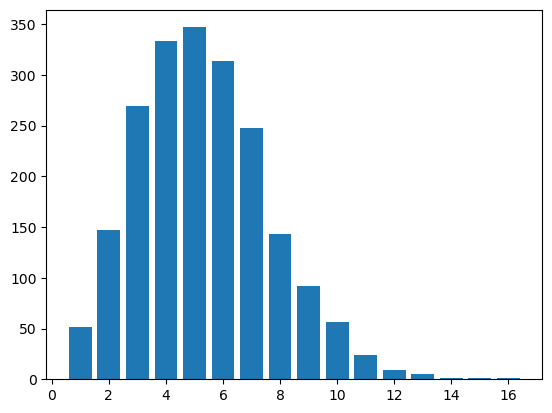

In [30]:
plt.bar(cnt_hc_1.keys(), cnt_hc_1.values())
plt.show()

In [31]:
cnt_hc_2= Counter(map(len, hash_conflicts_2.values()))
cnt_hc_2

Counter({89: 188,
         86: 185,
         85: 171,
         84: 169,
         87: 161,
         82: 159,
         90: 157,
         88: 156,
         83: 150,
         95: 143,
         91: 141,
         96: 138,
         80: 135,
         94: 132,
         97: 129,
         92: 129,
         81: 129,
         93: 126,
         79: 99,
         78: 97,
         77: 95,
         76: 95,
         100: 88,
         98: 84,
         99: 79,
         101: 72,
         75: 68,
         73: 59,
         102: 56,
         103: 55,
         104: 52,
         72: 46,
         105: 39,
         74: 39,
         71: 32,
         108: 31,
         70: 25,
         106: 24,
         107: 22,
         69: 21,
         68: 18,
         110: 16,
         111: 12,
         112: 11,
         65: 10,
         66: 10,
         109: 8,
         67: 7,
         114: 6,
         113: 4,
         116: 3,
         63: 2,
         120: 2,
         115: 2,
         62: 1,
         122: 1,
         58: 1,
     

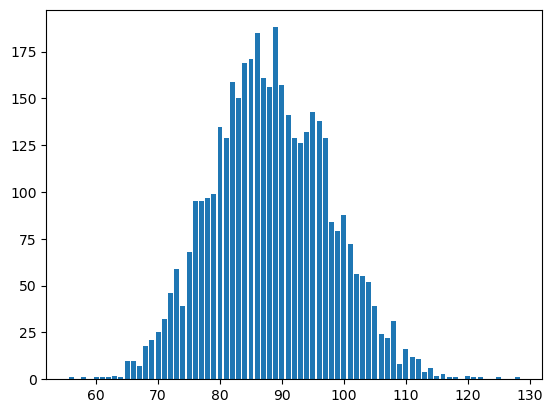

In [32]:
plt.bar(cnt_hc_2.keys(), cnt_hc_2.values())
plt.show()

In [33]:
cnt_hc_3 = Counter(map(len, hash_conflicts_3.values()))

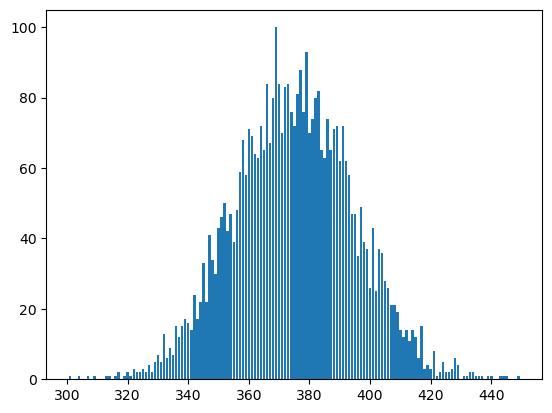

In [34]:
plt.bar(cnt_hc_3.keys(), cnt_hc_3.values())
plt.show()